## Foundations of Image Processing: Filtering and Fourier Analysis


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, data, exposure, transform, filters, util, metrics, feature
import cv2
from scipy.signal import convolve2d
from scipy.ndimage import uniform_filter

import torch
import torch.nn.functional as F

print("Library versions:")
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("cv2:", cv2.__version__)
print("pytorch:", torch.__version__)



Library versions:
numpy: 2.1.3
matplotlib: 3.10.1
cv2: 4.12.0
pytorch: 2.8.0+cu128


## A. Introduction ##

Why filtering matters (denoising, edge detection, feature extraction)?


Filtering is one of the core operations in image processing. By applying mathematical kernels or transformations to images, we can highlight important structures or suppress unwanted variations.
- **Denoising**: reduce random noise and improve image quality.
- **Edge detection**: emphasize boundaries that define shapes and objects.
- **Feature extraction**: prepare meaningful patterns for higher-level tasks in computer vision and AI.

In this section, we will explore how filtering provides the foundation for tasks ranging from simple enhancement to complex analysis such as recognition and classification.


Real-world images often contain **noise** from sensors, compression, or poor lighting. Filtering can reduce this noise and make important structures clearer.  

Here I add artificial noise to an image and then apply a **Gaussian blur filter** to smooth it. Notice how the filter reduces noise but also slightly blurs fine details — showing the trade-off in denoising.


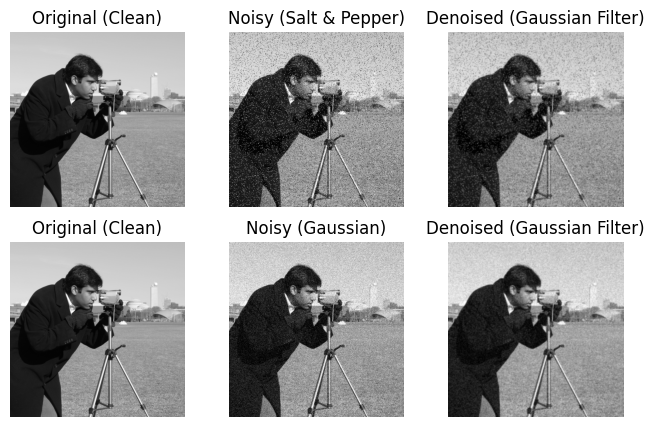

In [6]:
# --- Load a clean grayscale image ---
image = data.camera()

# --- Add artificial noise ---
noisy_sp = util.random_noise(image,mode='s&p',amount=0.1)
noisy_guss = util.random_noise(image,mode='gaussian')

# --- Apply Gaussian filter for denoising ---
denoised_sp = filters.gaussian(noisy_sp)
denoised_guss = filters.gaussian(noisy_guss)

# --- Display results side by side ---
fig, axes = plt.subplots(2, 3, figsize=(8, 5))

axes[0][0].imshow(image, cmap="gray")
axes[0][0].set_title("Original (Clean)")
axes[0][0].axis("off")

axes[0][1].imshow(noisy_sp, cmap="gray")
axes[0][1].set_title("Noisy (Salt & Pepper)")
axes[0][1].axis("off")

axes[0][2].imshow(denoised_sp, cmap="gray")
axes[0][2].set_title("Denoised (Gaussian Filter)")
axes[0][2].axis("off")

axes[1][0].imshow(image, cmap="gray")
axes[1][0].set_title("Original (Clean)")
axes[1][0].axis("off")

axes[1][1].imshow(noisy_guss, cmap="gray")
axes[1][1].set_title("Noisy (Gaussian)")
axes[1][1].axis("off")

axes[1][2].imshow(denoised_guss, cmap="gray")
axes[1][2].set_title("Denoised (Gaussian Filter)")
axes[1][2].axis("off")

plt.show()

Edges correspond to **sudden changes in intensity**, which often mark object boundaries. Detecting edges helps computers recognize shapes and structures, making it a key step in many vision tasks.  

Here we compare different edge detection methods:  
- **Sobel**: emphasizes horizontal and vertical edges.  
- **Prewitt**: similar to Sobel but slightly simpler.  
- **Canny**: a more advanced method that detects clean, thin edges.


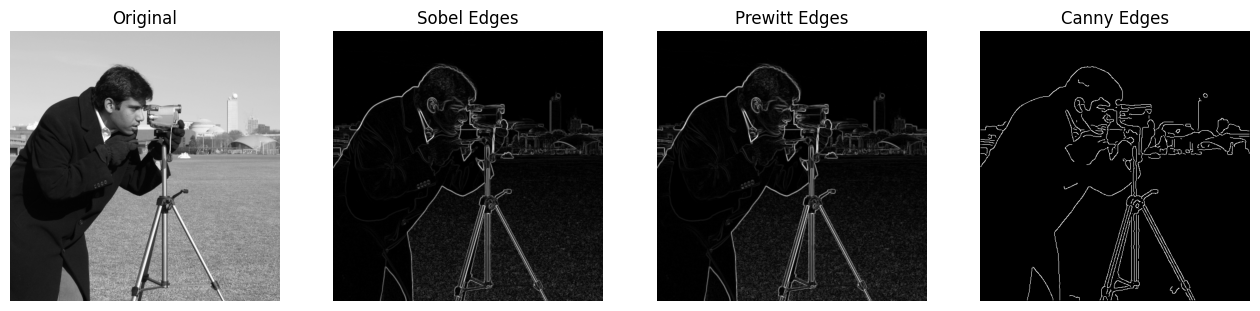

In [13]:
# --- Load a sample grayscale image ---
image = data.camera()

# --- Apply different edge detection methods ---
sobel_edges = filters.sobel(image)      # Sobel filter
prewitt_edges = filters.prewitt(image)    # Prewitt filter
canny_edges = feature.canny(image, sigma=2)    # Canny edge detector (sigma controls smoothing)

# --- Display original + edge-detected results ---
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(sobel_edges, cmap="gray")
axes[1].set_title("Sobel Edges")
axes[1].axis("off")

axes[2].imshow(prewitt_edges, cmap="gray")
axes[2].set_title("Prewitt Edges")
axes[2].axis("off")

axes[3].imshow(canny_edges, cmap="gray")
axes[3].set_title("Canny Edges")
axes[3].axis("off")

plt.show()

Feature extraction transforms an image into a **set of meaningful patterns** that can be used for machine learning or AI tasks. Instead of working with raw pixels, we compute **descriptors** that capture shapes, textures, or edges.  

Here we use **Histogram of Oriented Gradients (HOG)**:  
- It divides the image into small regions (cells).  
- For each region, it counts edge orientations (gradient directions).  
- The result emphasizes **object structure** while ignoring unnecessary details like lighting.  

This prepares the image for tasks such as object detection or recognition.


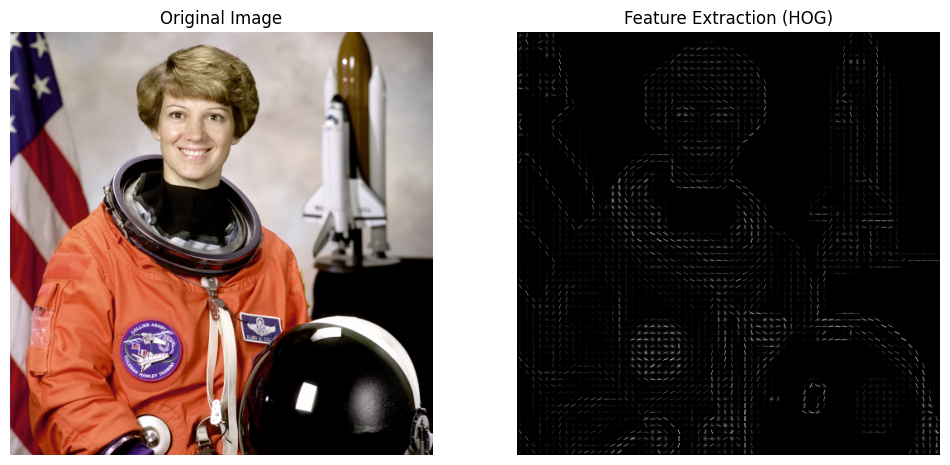

Extracted HOG feature vector length: 311364


In [17]:
# --- Load a sample grayscale image ---
image = data.astronaut()

gray_image = color.rgb2gray(image)  # convert to grayscale for feature extraction

# --- Compute HOG features and visualization ---

hog_features, hog_image = feature.hog(gray_image, visualize=True)

# --- Display original image and HOG visualization ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# The HOG visualization shows edges and patterns emphasized
axes[1].imshow(hog_image, cmap="gray")
axes[1].set_title("Feature Extraction (HOG)")
axes[1].axis("off")

plt.show()

print("Extracted HOG feature vector length:", len(hog_features))

## B. Convolution in 2D ##

Implement convolution manually in Python (no cv2.filter2D initially).


Convolution is the fundamental operation behind filtering. It works by sliding a **kernel (filter matrix)** across the image and computing weighted sums of pixel values.

 we will:  
- Implement convolution manually with NumPy.  
- Apply it using a simple edge-detection kernel (Sobel-like).  
- Verify our results against PyTorch’s built-in convolution.


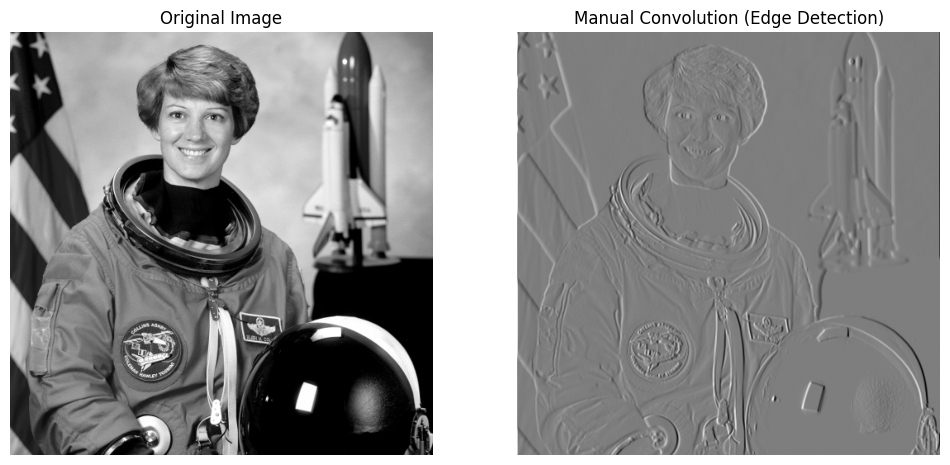

In [20]:
# --- Load grayscale test image ---
image = color.rgb2gray(data.astronaut())   # convert to grayscale

# --- Define a simple edge-detection kernel (Sobel-x like) ---
kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

# --- Manual convolution function ---
def conv2d_manual(img, kernel):
    kh, kw = kernel.shape
    ih, iw = img.shape
    
    # Output image (same size, so pad the input)
    pad_h, pad_w = kh // 2, kw // 2
    padded = np.pad(img, ((pad_h, pad_h),(pad_w, pad_w)))
    output = np.zeros((ih, iw))
    
    # Convolution operation
    for i in range(ih):
        for j in range(iw):
            region = padded[i:i+kh,j:j+kw]     # extract region
            output[i, j] = np.sum(region*kernel)
    return output

# --- Apply manual convolution ---
manual_edges = conv2d_manual(image, kernel)

# --- Show results ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(manual_edges, cmap="gray")
axes[1].set_title("Manual Convolution (Edge Detection)")
axes[1].axis("off")

plt.show()

Verification with PyTorch.


Mean absolute difference (manual vs PyTorch): 3.789518419574021e-08


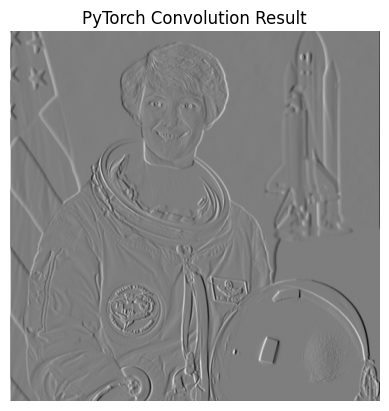

In [24]:
# Convert image and kernel to torch tensors
img_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape [1,1,H,W]
kernel_tensor = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape [1,1,kH,kW]

# Apply convolution
conv_result = F.conv2d(img_tensor, kernel_tensor, padding=1)  # padding=1 for same size
conv_result = conv_result.squeeze().numpy()

# Compare manual vs. PyTorch
diff = np.abs(manual_edges - conv_result).mean()
print("Mean absolute difference (manual vs PyTorch):", diff)

# Show PyTorch result
plt.imshow(conv_result, cmap="gray")
plt.title("PyTorch Convolution Result")
plt.axis("off")
plt.show()

## C. Linear Filters ##

Explore a few linear filters: Mean/box filter, Gaussian filter. Compare their effects on noise vs edges.


Linear filters apply a weighted average of nearby pixels to smooth an image. They are commonly used for **denoising**, but they affect edges differently:  

- **Mean (box) filter**: replaces each pixel with the average of its neighbors.  
  - Simple and effective for reducing random noise.  
  - Strongly blurs edges, since edges are also "averaged out."  

- **Gaussian filter**: applies a weighted average where closer pixels count more.  
  - Reduces noise while preserving edges better than a box filter.  
  - Mimics the effect of natural blurring (like a camera lens).  

Here we compare how these filters perform on a noisy image.


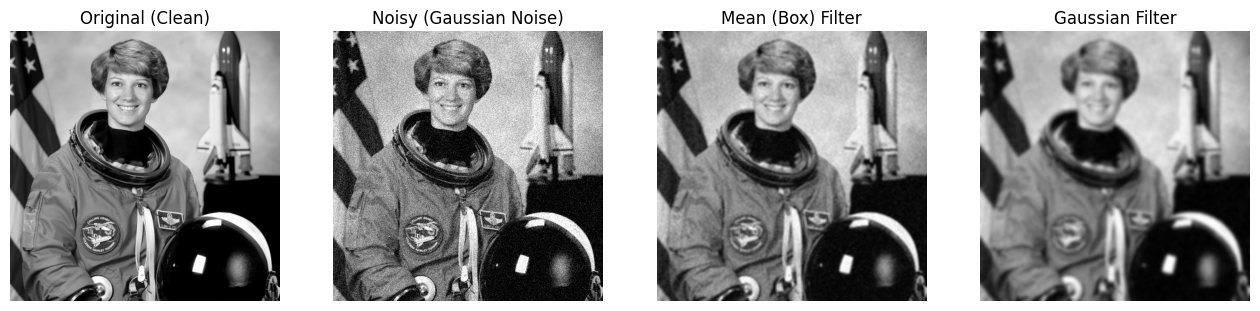

In [27]:
# --- Load a sample grayscale image ---
image = color.rgb2gray(data.astronaut())

# --- Add artificial Gaussian noise ---
noisy = util.random_noise(image, mode="gaussian", var=0.01)

# --- Apply Mean (box) filter ---
mean_filtered = filters.rank.mean(util.img_as_ubyte(noisy),np.ones((5, 5)))  # 5x5 averaging window

# --- Apply Gaussian filter ---
gaussian_filtered = filters.gaussian(noisy, sigma=3)  # sigma controls blur strength

# --- Display results ---
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original (Clean)")
axes[0].axis("off")

axes[1].imshow(noisy, cmap="gray")
axes[1].set_title("Noisy (Gaussian Noise)")
axes[1].axis("off")

axes[2].imshow(mean_filtered, cmap="gray")
axes[2].set_title("Mean (Box) Filter")
axes[2].axis("off")

axes[3].imshow(gaussian_filtered, cmap="gray")
axes[3].set_title("Gaussian Filter")
axes[3].axis("off")

plt.show()

## D. Fourier Transform of Images ##

In this section, we compute FFT and visualise magnitude spectrum. I will see correspondence between blur in spatial domain $\leftrightarrow$ low-pass in frequency domain, and experiment with two images and swapping phase/magnitude components.

The **Fourier Transform (FT)** decomposes an image into its frequency components.  

- Low frequencies: slow intensity variations (smooth regions, overall structure).  
- High frequencies: rapid intensity changes (edges, fine details).  

Key concepts:  
- Blurring in the **spatial domain** removes high frequencies $\rightarrow$ acts like a **low-pass filter**.  
- Sharpening in the **spatial domain** emphasizes high frequencies.


we will:  
1. Compute the **2D FFT** of an image.  
2. Visualize the **magnitude spectrum**.  
3. Show how **blurring in the spatial domain** corresponds to **low-pass filtering** in the frequency domain.


##### Step 1: Compute FFT and Spectrum


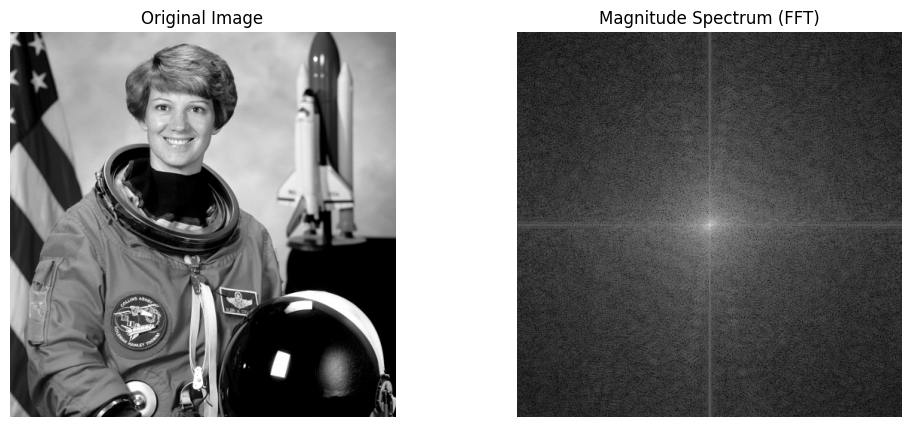

In [32]:
# --- Load a sample grayscale image ---
image = color.rgb2gray(data.astronaut())

# --- Compute 2D Fourier Transform ---
f = np.fft.fft2(image)            # compute FFT
fshift = np.fft.fftshift(f)       # shift zero frequency to the center
magnitude_spectrum = np.log(np.abs(fshift)+1)*20  # log scale for visibility

# --- Display image and its spectrum ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(magnitude_spectrum, cmap="gray")
axes[1].set_title("Magnitude Spectrum (FFT)")
axes[1].axis("off")

plt.show()

##### Step 2: Blur in Spatial Domain $\rightarrow$ Low-Pass in Frequency Domain


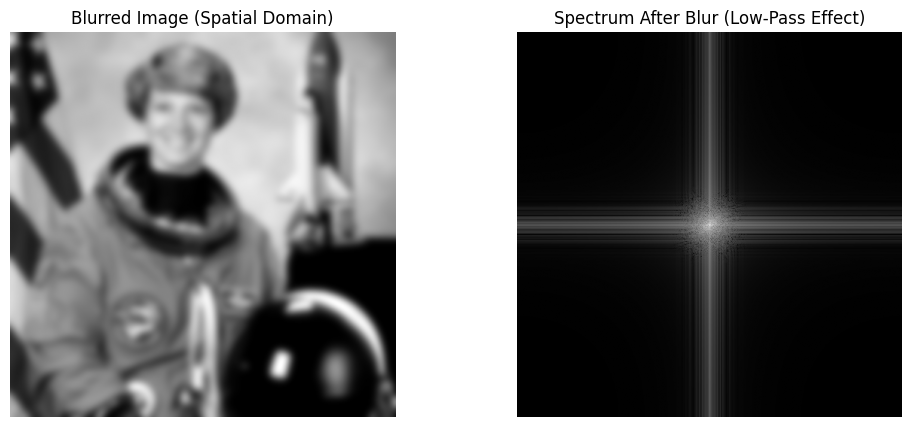

In [33]:
# --- Apply Gaussian blur to the image (spatial domain) ---
blurred = filters.gaussian(image, sigma=5)

# --- Compute FFT of blurred image ---
f_blur = np.fft.fft2(blurred)  # compute FFT
fshift_blur = np.fft.fftshift(f_blur)   # shift zero frequency to the center
magnitude_spectrum_blur = np.log(np.abs(fshift_blur)+1)*20  # log scale for visibility

# --- Display blurred image and its spectrum ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(blurred, cmap="gray")
axes[0].set_title("Blurred Image (Spatial Domain)")
axes[0].axis("off")

axes[1].imshow(magnitude_spectrum_blur, cmap="gray")
axes[1].set_title("Spectrum After Blur (Low-Pass Effect)")
axes[1].axis("off")

plt.show()

##### Step 3: Show how blurring in the spatial domain corresponds to low-pass filtering in the frequency domain.


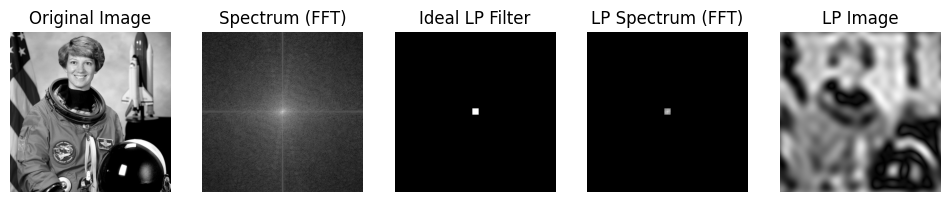

In [35]:
# --- Compute FFT of original image ---
f = np.fft.fft2(image)  # compute FFT
fshift = np.fft.fftshift(f)  # shift zero frequency to the center
magnitude_spectrum = np.log(np.abs(fshift)+1)*20  # log scale for visibility

# --- Create Ideal Low-Pass Filter (white box mask) ---
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2   # center of the frequency domain

radius = 10   # cutoff radius (adjust for blur strength)
mask = np.zeros((rows, cols))
mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 1

# --- Apply mask (filtering in frequency domain) ---
fshift_filtered = mask * fshift
magnitude_spectrum_LP = np.log(np.abs(fshift_filtered)+1)*20  # log scale for visibility

# --- Inverse FFT to reconstruct the filtered image ---
f_ishift = np.fft.ifftshift(fshift_filtered)  # shift zero frequency to the center
img_filtered = np.fft.ifft2(f_ishift)  # Inverse FFT
img_filtered = np.abs(img_filtered)

# --- Display blurred image and its spectrum ---
fig, axes = plt.subplots(1, 5, figsize=(12, 5))

plt.subplot(1, 5, 1)
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

plt.subplot(1, 5, 2)
axes[1].imshow(magnitude_spectrum, cmap="gray")
axes[1].set_title("Spectrum (FFT)")
axes[1].axis("off")

plt.subplot(1, 5, 3)
axes[2].imshow(mask, cmap='gray')
axes[2].set_title("Ideal LP Filter")
axes[2].axis('off')

plt.subplot(1, 5, 2)
axes[3].imshow(magnitude_spectrum_LP, cmap="gray")
axes[3].set_title("LP Spectrum (FFT)")
axes[3].axis("off")

plt.subplot(1, 5, 5)
axes[4].imshow(img_filtered, cmap='gray')
axes[4].set_title("LP Image")
axes[4].axis('off')

plt.show()

In the Fourier domain:  
- The **magnitude** (or amplitude) controls the strength of different frequencies.  
- The **phase** controls how those frequencies are aligned to form structures.  

 we take two different images, compute their Fourier transforms, and then reconstruct hybrids by swapping their **magnitude** and **phase** components.


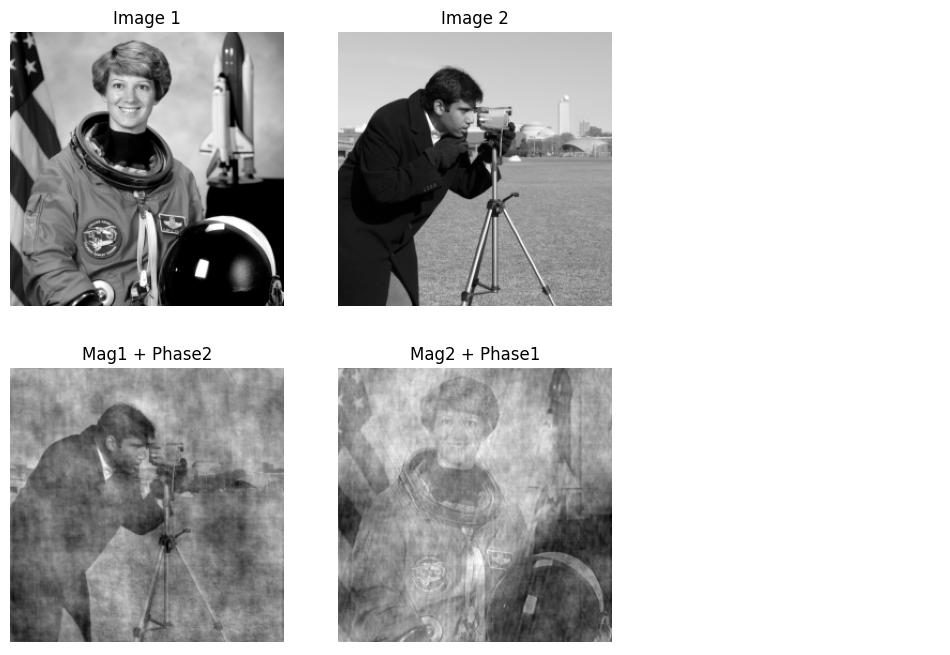

In [36]:
img1 = color.rgb2gray(data.astronaut())
img2 = data.camera()

# Resize to the same shape for FFT
shape = (256, 256)
img1 = transform.resize(img1, shape, anti_aliasing=True)
img2 = transform.resize(img2, shape, anti_aliasing=True)

# --- Compute FFTs ---
f1 = np.fft.fft2(img1)
f2 = np.fft.fft2(img2)

# Separate magnitude and phase
mag1, phase1 = np.abs(f1),np.angle(f1)
mag2, phase2 = np.abs(f2),np.angle(f2)

# --- Swap combinations ---
# Image 1's magnitude + Image 2's phase
swap1 = np.real(np.fft.ifft2(mag1*np.exp(1j*phase2)))

# Image 2's magnitude + Image 1's phase
swap2 = np.real(np.fft.ifft2(mag2*np.exp(1j*phase1)))

# --- Display results ---
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0,0].imshow(img1, cmap="gray")
axes[0,0].set_title("Image 1")
axes[0,0].axis("off")

axes[0,1].imshow(img2, cmap="gray")
axes[0,1].set_title("Image 2")
axes[0,1].axis("off")

axes[0,2].axis("off")  # empty placeholder

axes[1,0].imshow(swap1, cmap="gray")
axes[1,0].set_title("Mag1 + Phase2")
axes[1,0].axis("off")

axes[1,1].imshow(swap2, cmap="gray")
axes[1,1].set_title("Mag2 + Phase1")
axes[1,1].axis("off")

axes[1,2].axis("off")  # empty placeholder

plt.show()

**Surprisingly, the **phase** carries most of the structural information of an image.**


Reflection (Not needed to answer):
- Which image structure dominates after swapping — the one providing magnitude or the one providing phase?  
- What does this tell us about the relative importance of phase vs. magnitude in perception? 
- Try experimenting with other image pairs. What happens when the images are very different?


## E. Image Derivatives ##

In image processing, the **derivative** measures how pixel values change across space.  
- **First-order derivatives (gradients)** detect edges and highlight regions with rapid intensity change. 
- **Prewitt operator** detects edges by measuring intensity changes in the horizontal and vertical directions. 
- **Second-order derivatives** (like the Laplacian) capture areas where intensity changes rapidly in multiple directions.  

Key uses:  
- Edge detection  
- Feature extraction  
- Building blocks for higher-level methods (e.g., optical flow, texture analysis)  

In this section, we compute image derivatives and visualize their effects.


##### Step 1: First-order Derivatives (Sobel Gradients)


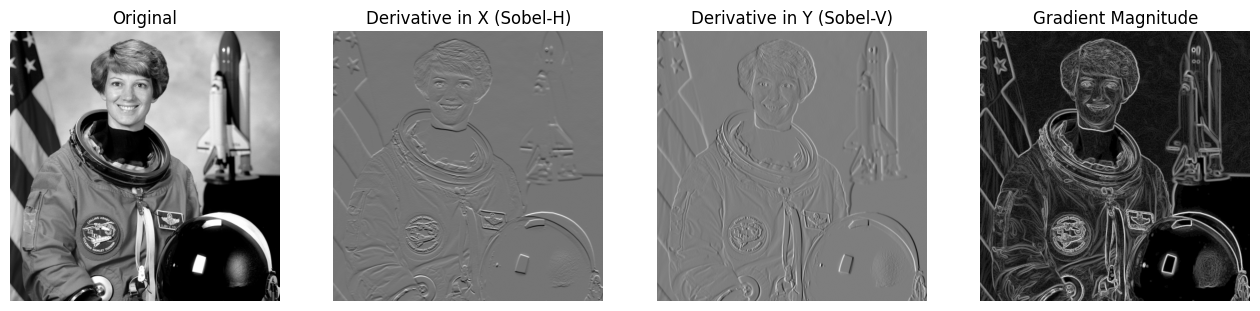

In [37]:
# --- Load grayscale image ---
image = color.rgb2gray(data.astronaut())

# --- Compute first-order derivatives using Sobel operator ---
grad_x = filters.sobel_h(image)   # horizontal derivative (changes along x-axis)
grad_y = filters.sobel_v(image)   # vertical derivative (changes along y-axis)

# --- Compute gradient magnitude (overall edge strength) ---
grad_mag = np.sqrt(np.sqrt(grad_x**2+grad_y**2))

# --- Display results ---
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(grad_x, cmap="gray")
axes[1].set_title("Derivative in X (Sobel-H)")
axes[1].axis("off")

axes[2].imshow(grad_y, cmap="gray")
axes[2].set_title("Derivative in Y (Sobel-V)")
axes[2].axis("off")

axes[3].imshow(grad_mag, cmap="gray")
axes[3].set_title("Gradient Magnitude")
axes[3].axis("off")

plt.show()

##### Step 2: Prewitt Filter for Image Derivatives

The **Prewitt operator** is another way to approximate image derivatives.  
The main difference: Prewitt uses uniform weights, while Sobel gives more weight to the center row/column.


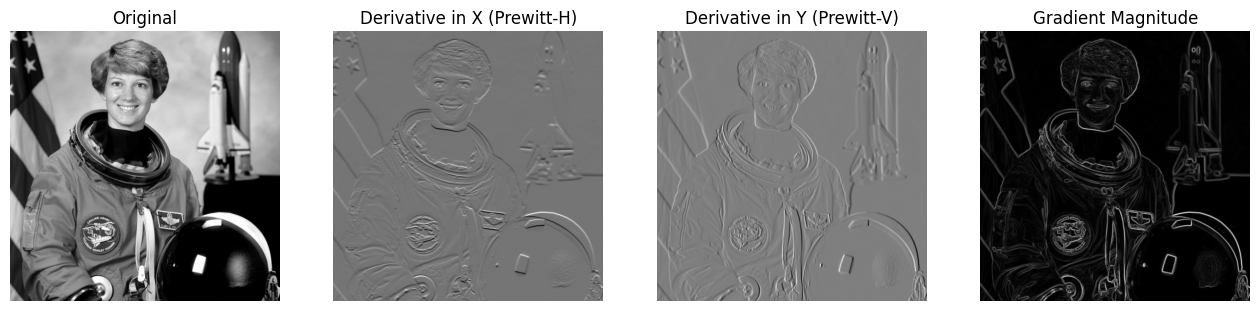

In [38]:
# --- Load grayscale image ---
image = color.rgb2gray(data.astronaut())

# --- Compute Prewitt derivatives ---
grad_x = filters.prewitt_h(image)   # horizontal derivative
grad_y = filters.prewitt_v(image)   # vertical derivative

# --- Gradient magnitude (edge strength) ---
grad_mag = np.sqrt(grad_x**2+grad_y**2)

# --- Display results ---
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(grad_x, cmap="gray")
axes[1].set_title("Derivative in X (Prewitt-H)")
axes[1].axis("off")

axes[2].imshow(grad_y, cmap="gray")
axes[2].set_title("Derivative in Y (Prewitt-V)")
axes[2].axis("off")

axes[3].imshow(grad_mag, cmap="gray")
axes[3].set_title("Gradient Magnitude")
axes[3].axis("off")

plt.show()

##### Step 3: Second-order Derivatives (Laplacian)


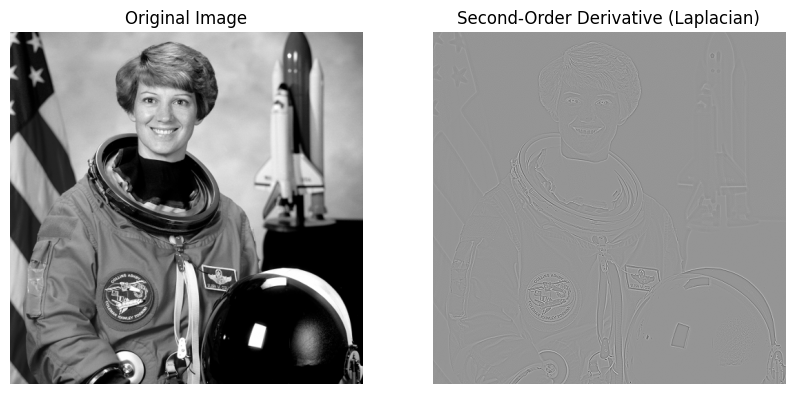

In [39]:
from scipy.ndimage import laplace

# --- Apply Laplacian filter (second-order derivative) ---
laplacian_img = laplace(image)

# --- Display original vs Laplacian ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(laplacian_img, cmap="gray")
axes[1].set_title("Second-Order Derivative (Laplacian)")
axes[1].axis("off")

plt.show()

## F. Blur Filters and Edge Loss ##

Blurring is often used for **denoising** or **smoothing**, but it comes at a cost: it reduces high-frequency details, which means **edges become weaker or disappear**.  

To see this, we will:  
1. Apply Gaussian blur with increasing `sigma` values.  
2. Compute image derivatives (using Sobel).  
3. Compare how edge strength degrades as the blur increases.


we apply Gaussian blur with different values of `sigma`. A higher `sigma` means stronger smoothing and more loss of detail.


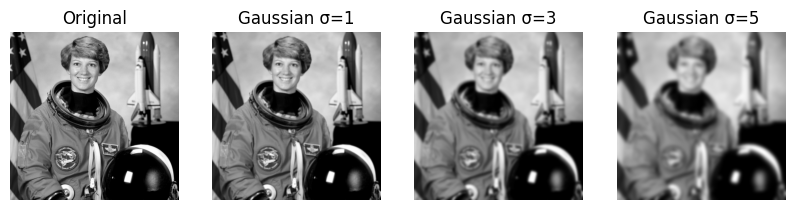

In [40]:
# --- Load grayscale image ---
image = color.rgb2gray(data.astronaut())

# --- Apply Gaussian blur with different sigma values ---
blur_sigma1 = filters.gaussian(image, sigma=1) # sigma is 1
blur_sigma3 = filters.gaussian(image, sigma=3) # sigma is 3
blur_sigma5 = filters.gaussian(image, sigma=5) # sigma is 5

# --- Display results ---
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
images = [image, blur_sigma1, blur_sigma3, blur_sigma5]
titles = ["Original", "Gaussian σ=1", "Gaussian σ=3", "Gaussian σ=5"]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.show()

Here I compute Sobel edge maps of the blurred images. As `sigma` increases, edges become weaker, showing the loss of high-frequency information.


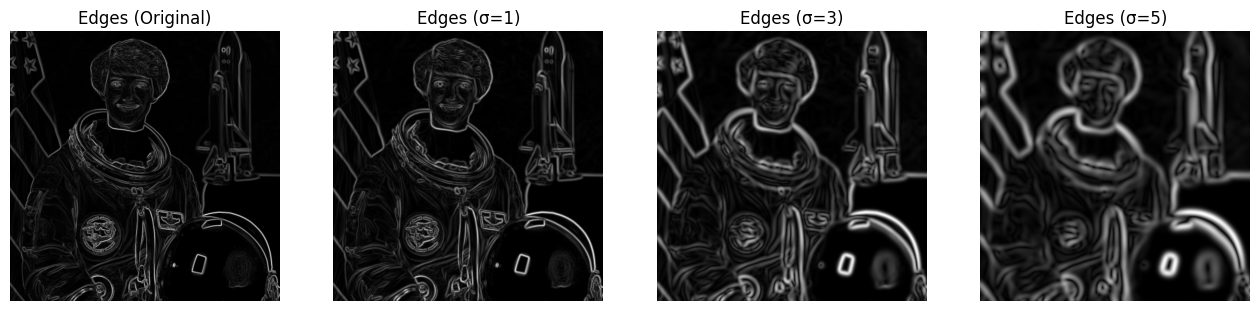

In [42]:
# --- Compute Sobel gradient magnitude for each version ---
def sobel_magnitude(img):
    grad_x = filters.sobel_h(img)
    grad_y = filters.sobel_v(img)
    return np.sqrt(grad_x**2+grad_y**2)

edges_original = sobel_magnitude(image)
edges_sigma1 = sobel_magnitude(blur_sigma1)
edges_sigma3 = sobel_magnitude(blur_sigma3)
edges_sigma5 = sobel_magnitude(blur_sigma5)

# --- Display edge maps side by side ---
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
edge_maps = [edges_original, edges_sigma1, edges_sigma3, edges_sigma5]
titles = ["Edges (Original)", "Edges (σ=1)", "Edges (σ=3)", "Edges (σ=5)"]

for ax, img, title in zip(axes, edge_maps, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.show()

## G. Temporal Filters (Video) ##

So far, we have applied filters in the **spatial domain** (within one image). For videos, we can also filter across **time** to process sequences of frames.  

Two common operations are:  
1. **Frame differencing** – detect motion by subtracting consecutive frames.
2. **Temporal low-pass filtering** – smooth pixel values across frames to reduce flicker or noise.


we simulate motion by shifting an image across frames. By subtracting consecutive frames, we highlight regions that change — which corresponds to motion.


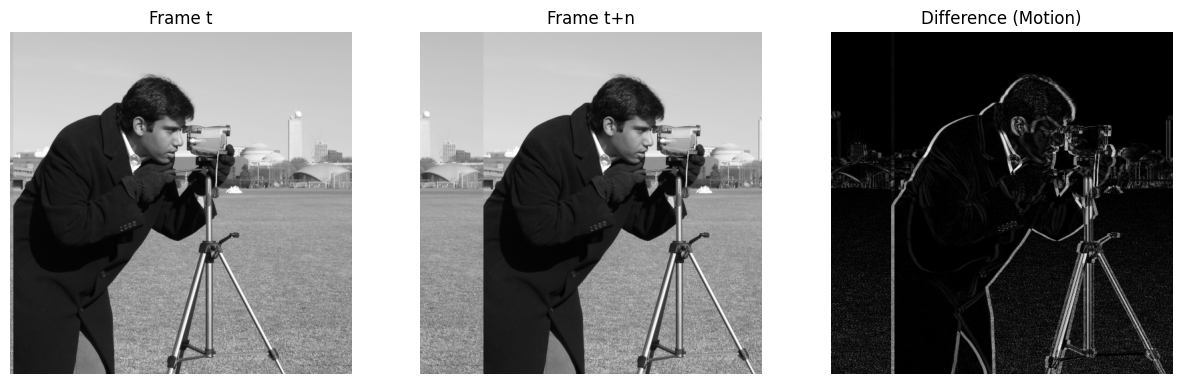

In [43]:
# --- Create a synthetic video sequence (moving image) ---
base = data.camera()
n = 20  # number of frames
idx = 19  # index of the frame for visualization
frames = [np.roll(base,shift=i*5,axis=1) for i in range(n)]  # shift right by 5 pixels each frame 

# --- Compute frame differences (motion detection) ---
diffs = [np.abs(frames[i+1].astype(float)-frames[i].astype(float)) for i in range(len(frames)-1)]

# --- Display one example pair of frames and their difference ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(frames[1], cmap="gray")
axes[0].set_title("Frame t")
axes[0].axis("off")

axes[1].imshow(frames[idx], cmap="gray")
axes[1].set_title("Frame t+n")
axes[1].axis("off")

axes[2].imshow(diffs[idx-1], cmap="gray")
axes[2].set_title("Difference (Motion)")
axes[2].axis("off")

plt.show()

Here I reduce flicker by averaging frames over time. This is like a low-pass filter in the temporal domain — it keeps slow changes while suppressing fast changes (flicker, noise).


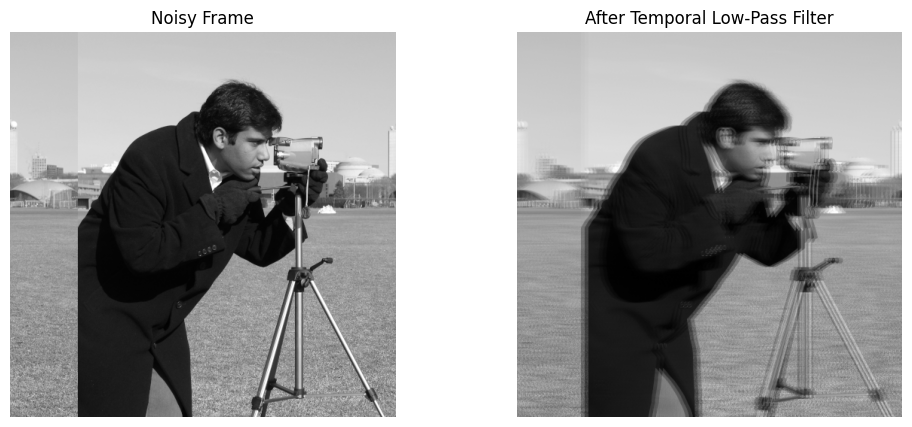

In [46]:
# --- Create a synthetic noisy video sequence ---
n = 20  # number of frames
idx = 18  # index of the frame for visualization
rng = np.random.default_rng(0)
noisy_frames = [np.roll(base,shift=i*5,axis=1) + rng.normal() for i in range(n)]  # shift right by 5 pixels each frame (base + Gaussian noise)

# --- Temporal low-pass filter: simple moving average ---
smoothed_frames = []
for i in range(len(noisy_frames)):
    # Average current frame with its neighbors (window size = 3)
    start, end = max(0, i-1), min(len(noisy_frames), i+2)
    smoothed = np.mean(noisy_frames[start:end], axis=0)
    smoothed_frames.append(smoothed)

# --- Display one noisy frame vs. its smoothed version ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(noisy_frames[idx], cmap="gray")
axes[0].set_title("Noisy Frame")
axes[0].axis("off")

axes[1].imshow(smoothed_frames[idx], cmap="gray")
axes[1].set_title("After Temporal Low-Pass Filter")
axes[1].axis("off")

plt.show()


## H. Exercises ##

In this final section, I will implement and experiment with **custom filters**. The goal is to understand how different kernels affect images, and to creatively design your own filters.

- Implement a custom filter kernel.
- Explore sharpening (unsharp mask).
- Design a filter that removes horizontal vs. vertical patterns.


Here I will define your own $3\times3$ kernel and apply convolution manually. Try designing a blur kernel, edge detector, or emboss effect.


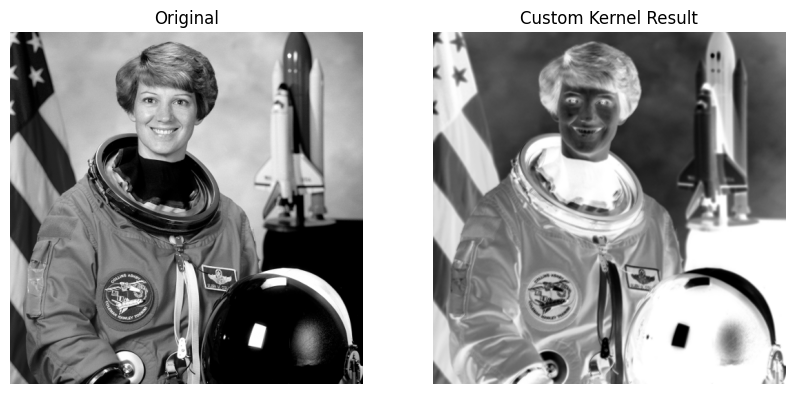

In [49]:
# --- Load grayscale image ---
image = color.rgb2gray(data.astronaut())

# Example: simple edge detection
custom_kernel = np.array([[-1, 0, -1], [0, -1, -1], [0, -1, 0]])

# --- Apply convolution with your kernel ---
filtered = convolve2d(image, custom_kernel, mode='same', boundary='symm')

# --- Show results ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(filtered, cmap="gray")
axes[1].set_title("Custom Kernel Result")
axes[1].axis("off")

plt.show()

Sharpening enhances edges by adding back details lost in smoothing. The unsharp mask works by subtracting a blurred version of the image from the original, then adding this difference back.


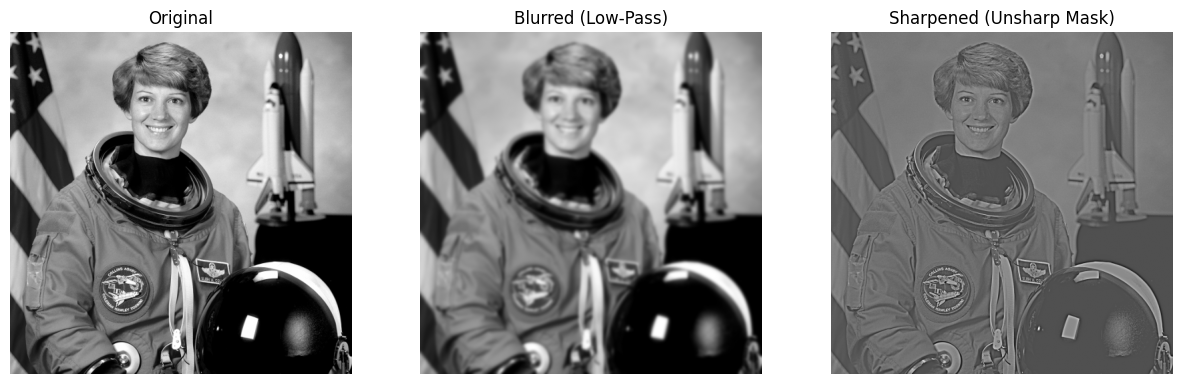

In [52]:
# --- Blur the image (low-pass) ---
blurred = filters.gaussian(image, sigma=2)

# --- Compute the mask (original - blurred) ---
mask = image-blurred

# --- Create sharpened image: original + amount * mask ---
sharpened = image + 3*mask

# --- Show results ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(blurred, cmap="gray")
axes[1].set_title("Blurred (Low-Pass)")
axes[1].axis("off")

axes[2].imshow(sharpened, cmap="gray")
axes[2].set_title("Sharpened (Unsharp Mask)")
axes[2].axis("off")

plt.show()

Here, I will design filters that suppress patterns in one direction.
- Use a horizontal edge detector (emphasizes horizontal lines, suppresses vertical).
- Use a vertical edge detector (emphasizes vertical lines, suppresses horizontal).


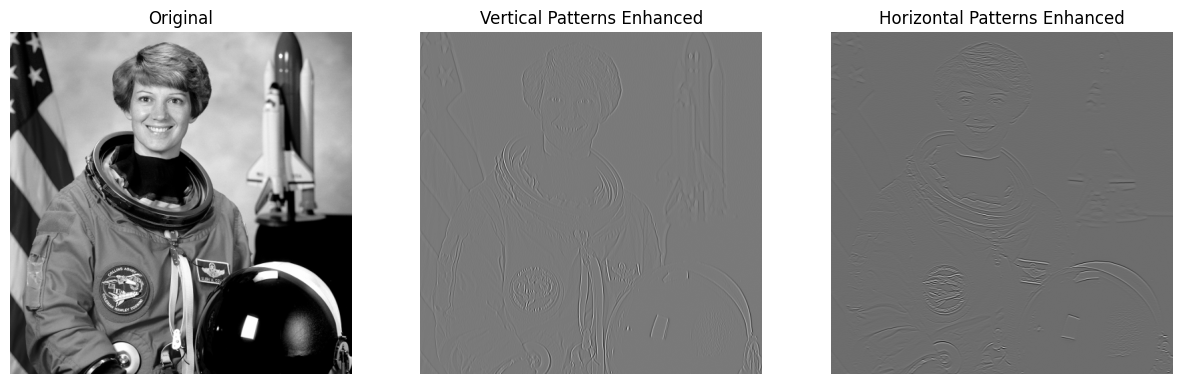

In [56]:
# --- Define directional kernels ---
# Detect vertical structures (suppress horizontal)
kernel_vertical = np.array([[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]])

# Detect horizontal structures (suppress vertical)
kernel_horizontal = np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]])

# --- Apply convolutions ---
filtered_vertical = convolve2d(image, kernel_vertical, mode='same', boundary='symm')
filtered_horizontal = convolve2d(image, kernel_horizontal, mode='same', boundary='symm')

# --- Show results ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(filtered_vertical, cmap="gray")
axes[1].set_title("Vertical Patterns Enhanced")
axes[1].axis("off")

axes[2].imshow(filtered_horizontal, cmap="gray")
axes[2].set_title("Horizontal Patterns Enhanced")
axes[2].axis("off")

plt.show()